In [1]:
# incluimos las librerias que vamos a utilizar
import numpy as np 
import pandas as pd
import datetime as datetime

# plots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline

In [2]:
# cargamos los datos
events = pd.read_csv('events.csv', low_memory = False)
# categorizamos
events['timestamp'] = pd.to_datetime(events['timestamp'], errors = 'coerce', format= '%Y-%m-%d')
events['event'] = events['event'].astype('category')

In [3]:
events['marca'] = events['model'].str.split(' ').str[0]
events['modelo'] = events['model'].str.split(' ').str[1].fillna('') + ' ' + events['model'].str.split(' ').str[2].fillna('')
events[['marca', 'modelo']].head()

,marca,modelo
0,NaN,
1,NaN,
2,iPhone,5s
3,iPhone,5s
4,Samsung,Galaxy S8


In [4]:
# personas que se suscribieron para un producto
# no se suscriben a muchos productos, ¿por qué?
leaded_events = events[events['event'] == 'lead']
leaded_persons = leaded_events[['person','timestamp']] 
leaded_persons = leaded_persons.groupby('person').agg({'timestamp':'count'}).reset_index()
leaded_persons.columns = ['person', 'leaded products'] 
leaded_persons = leaded_persons.sort_values(by='leaded products', ascending=False)
leaded_persons.head()

,person,leaded products
176,97e0bcf2,16
87,52a4edd3,11
93,58692743,8
164,8dd8c1b4,6
237,d5661793,5


Text(0,0.5,'Cantidad de usuarios')

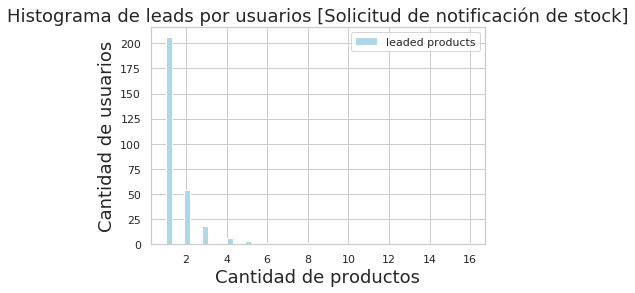

In [5]:
g = leaded_persons.plot.hist(bins=50, color='lightblue')
g.set_title("Histograma de leads por usuarios [Solicitud de notificación de stock]", fontsize=18)
g.set_xlabel("Cantidad de productos",fontsize=18)
g.set_ylabel("Cantidad de usuarios", fontsize=18)

In [6]:
# personas que volvieron por canal = EMAIL (ver si esto esta bien.
# entiendo que la notif del producto listo llega por email)
returning = events[(events['new_vs_returning'] == 'Returning') & (events['channel'] == 'Email')][['person', 'timestamp', 'channel']]
returning.head()

,person,timestamp,channel
10786,02d599d3,2018-03-12 21:05:50,Email
31946,08cd79ec,2018-04-01 21:01:08,Email
41690,0bb3e374,2018-05-06 23:14:11,Email
88856,1880d52f,2018-05-06 14:01:30,Email
124947,2169c977,2018-04-18 08:41:24,Email


In [7]:
# personas que se suscribieron y volvieron ( son muy pocas )
a = pd.merge(leaded_events[['person','timestamp']] , returning, on='person', how='left')
a = a[(a['timestamp_y'] > a['timestamp_x'])] # fecha de retorno > fecha de lead
a = a.groupby('person').agg({'timestamp_y': pd.Series.nunique})
a.reset_index(inplace = True)
a.columns = ['person', 'times back'] 
a

,person,times back
0,50ee5606,1
1,52a4edd3,3
2,f3b4afa1,1


In [8]:
# veo cuantos de los que marcaron un producto como lead, lo terminan comprando

In [9]:
conversion_events = events[events['event'] == 'conversion']
leaded_models = leaded_events[['person','timestamp', 'marca', 'modelo']] 
converted_models = conversion_events[['timestamp', 'person', 'marca', 'modelo']]
merged = pd.merge(leaded_models, converted_models, on='person', how='left')
merged = merged[merged['timestamp_x'] < merged['timestamp_y']]
merged = merged.groupby(['person', 'timestamp_y', 'marca_y', 'modelo_y'], as_index=False)[['marca_x', 'modelo_x']].aggregate(lambda x: list(x))
merged.head(10)

,person,timestamp_y,marca_y,modelo_y,marca_x,modelo_x
0,03bdcd81,2018-01-09 16:47:50,Samsung,Galaxy S6,[Samsung],[Galaxy S7]
1,19b38ba2,2018-03-30 08:24:58,Sony,Xperia M4,[Sony],[Xperia M4]
2,19b38ba2,2018-03-30 16:01:02,Samsung,Galaxy J7,[Sony],[Xperia M4]
3,19b38ba2,2018-03-30 19:15:28,Samsung,Galaxy S5,[Sony],[Xperia M4]
4,19b38ba2,2018-03-31 04:33:57,Sony,Xperia M4,[Sony],[Xperia M4]
5,19b38ba2,2018-04-03 07:23:18,Samsung,Galaxy A5,[Sony],[Xperia M4]
6,19b38ba2,2018-04-11 15:20:25,LG,G4 H815P,"[Sony, LG]","[Xperia M4, G4 H815P]"
7,19b38ba2,2018-05-10 22:50:34,Samsung,Galaxy J7,"[Sony, LG]","[Xperia M4, G4 H815P]"
8,19fe94db,2018-04-23 00:56:23,Samsung,Galaxy J5,"[Samsung, Samsung]","[Galaxy J7, Galaxy J3]"
9,1ac00500,2018-04-16 18:55:43,Sony,Xperia Z3,"[Motorola, Samsung]","[Moto G4, Galaxy A7]"


In [10]:
# veo quienes compraron la misma marca 
merged['misma_marca'] = merged.apply(lambda x: x.marca_y in x.marca_x, axis=1)
merged['misma_marca'].value_counts()

True     75
False    24
Name: misma_marca, dtype: int64

In [11]:

# veo quienes compraron la misma marca y modelo
merged['misma_marca_modelo'] = merged[merged['misma_marca'] == True].apply(lambda x: x.modelo_y in x.modelo_x, axis=1, )
merged['misma_marca_modelo'].fillna(value=False, inplace=True)

a = merged.groupby(['misma_marca', 'misma_marca_modelo']).agg({'person':'count'})
a = a.reset_index().pivot_table(index='misma_marca',columns='misma_marca_modelo',values='person').fillna(0)
a.index = ['No', 'Si']
a.columns = ['No', 'Si']
a.index.name = 'Misma marca'
a.columns.name = 'Mismo modelo'
a.sort_values(by='No', ascending=False, inplace=True)
a = a[['Si', 'No']]
a


Mismo modelo,Si,No
Misma marca,,
Si,42.0,33.0
No,0.0,24.0


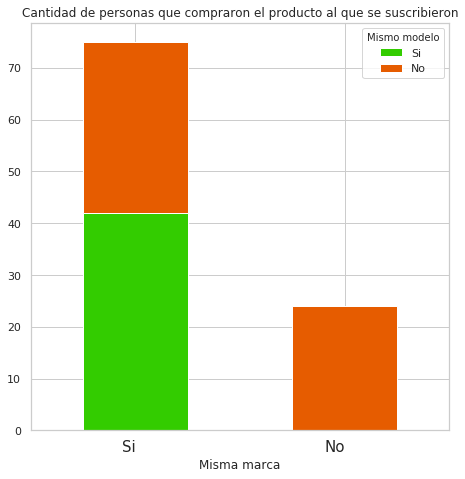

In [25]:

# graficar lo de arriba.
# la mayoría vuelve a comprar el mismo producto, o un modelo diferente pero de la misma marca
# hay mucha gente que no volvió a comprar (¿por que? ¿falta enviar mails, reponer stock?)
a_plot = a.plot(kind='bar', stacked=True, color=['#33cc00', '#e65c00'], figsize=(7.5,7.5));
a_plot.set_title('Cantidad de personas que compraron el producto al que se suscribieron')
a_plot.set_xticklabels(a_plot.get_xticklabels(), rotation = 0, fontsize = 15,ha="right");

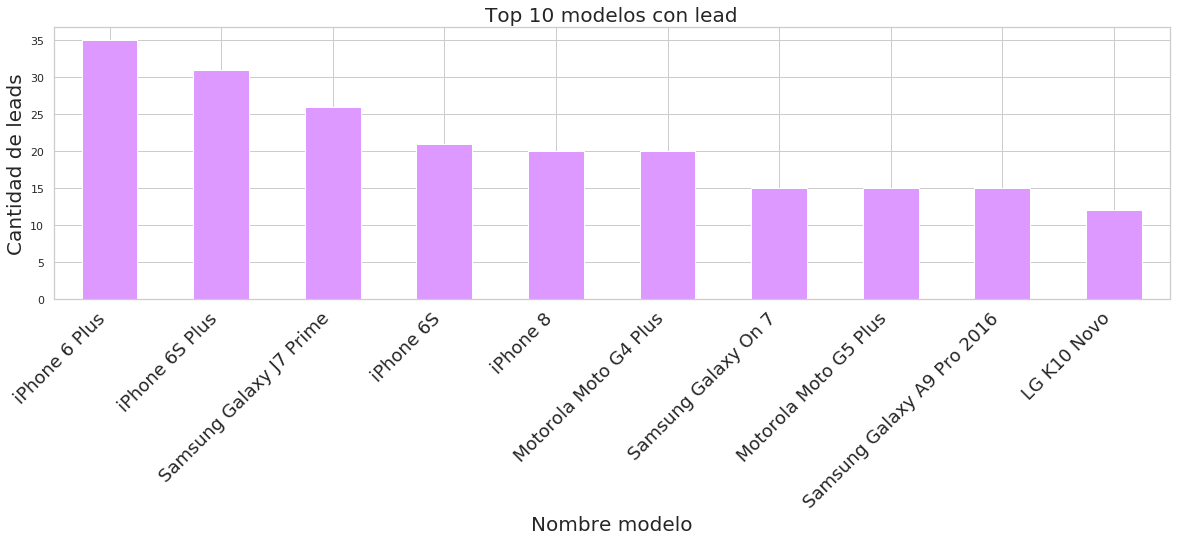

In [13]:
leaded_models = leaded_events[['timestamp', 'model']].groupby('model').agg({'timestamp':'count'}).sort_values(by='timestamp', ascending=False)

g = leaded_models.head(10).plot(kind = 'bar', figsize = (20,5), color = '#dd99ff',)
g.set_title('Top 10 modelos con lead', fontsize = 20)
g.set_xlabel('Nombre modelo', fontsize = 20)
g.set_ylabel('Cantidad de leads', fontsize = 20)
g.set_xticklabels(g.get_xticklabels(), rotation = 45, fontsize = 18 ,ha="right")
g.legend().set_visible(False)
